In [4]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import time
import math
import matplotlib.pyplot as plt
import subprocess
import shutil
import psutil # or import multiprocessing

annoying_print = False
do_print_to_file = True

total_cpus = psutil.cpu_count()

seed = 4734
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(42) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f'Número de GPUs disponibles: {num_gpus}')

Using cuda device
Número de GPUs disponibles: 4


### DATOS

In [5]:
# Cargar datos numpy normalizados - imagenes y velocidades

# Rutas de trabajo
npy_folder = '/disk2/alma/tesisSpace/'
numpy_file_name_image = "numpyFile_simulation_images"
numpy_file_name_velocity_x = "./numpyFile_simulation_velocity_x"
numpy_file_name_velocity_y = "./numpyFile_simulation_velocity_y"

def load_normalize_data():
    
    # Mensaje de depuración
    print("Ready to load NUMPY images_normalize from " + npy_folder)
    sys.stdout.flush()

    # Carga del archivo de imagenes
    try:
        data_norm_img = np.load(npy_folder + numpy_file_name_image + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_image + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_image + ".npy was loaded.")
        sys.stdout.flush()

    # Carga del archivo de velocidades por el momento se toman velocidades verticales y horizontales por separado (Velocidades del gas)

    try:
        data_norm_vx = np.load(npy_folder + numpy_file_name_velocity_x + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_velocity_x + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_velocity_x + ".npy was loaded.")
        sys.stdout.flush()

    try:
        data_norm_vy = np.load(npy_folder + numpy_file_name_velocity_y + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_velocity_y + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_velocity_y + ".npy was loaded.")
        sys.stdout.flush()

    
    # Retorno de las matrices numpy
    return data_norm_img, data_norm_vx, data_norm_vy


In [6]:
def adapt_training_data_PyTorch(data_img_norm, data_vel_norm):
    print("\n ADAPTING DATA FOR PYTORCH___________________________")
    
    # Imprimir detalles iniciales del array de datos
    print("I1 dtype =", data_img_norm.dtype, "- shape =", data_img_norm.shape)
    print("V1 dtype =", data_vel_norm.dtype, "- shape =", data_vel_norm.shape)
    
    # Expandir el array de imágenes para incluir el canal como una dimensión adicional
    # (batch_size, time_step, pix, pix) ---> (batch_size, time_step, pix, pix, 1)
    data_img_norm = np.expand_dims(data_img_norm, axis=4)
    print("I2 dtype =", data_img_norm.dtype, "- shape =", data_img_norm.shape)

    # Expandir el array de velocidades para incluir el canal como una dimensión adicional
    # (batch_size, pix, pix) ---> (batch_size, pix, pix, 1)
    data_vel_norm = np.expand_dims(data_vel_norm, axis=3)
    print("V2 dtype =", data_vel_norm.dtype, "- shape =", data_vel_norm.shape)

    print("\n")
    sys.stdout.flush()

    print("READY TO SELECT IMAGES TO TRAIN, VALIDATE & TEST______________________")
    sys.stdout.flush()
    
    # Inicialización de listas de índices
    random_list_indexes_train = []
    random_list_indexes_valid = []
    random_list_indexes_test = []
    
    total_data_len = data_img_norm.shape[0]

    # Crear índices para dividir los datos
    indices = np.arange(total_data_len)
    
    # Dividir los datos en conjuntos de entrenamiento + validación y prueba
    random_indexes_valid, random_indexes_test = train_test_split(
        indices, test_size=0.1, random_state=23)
    
    # Dividir los datos de entrenamiento + validación en entrenamiento y validación
    random_indexes_train, random_indexes_valid = train_test_split(
        random_indexes_valid, test_size=0.333, random_state=23)
    
    # Selección de imágenes para los conjuntos de entrenamiento, validación y prueba
    train_images = data_img_norm[random_indexes_train, :, :, :]
    valid_images = data_img_norm[random_indexes_valid, :, :, :]
    test_images = data_img_norm[random_indexes_test, :, :, :]
    print("Train_images dtype =", train_images.dtype, "- shape =", train_images.shape)
    print("Valid_images =", valid_images.dtype, "- shape =", valid_images.shape)
    print("Test_images =", test_images.dtype, "- shape =", test_images.shape)
    print("\n")
    sys.stdout.flush()

    train_velocitys = data_vel_norm[random_indexes_train, :, :, :]
    valid_velocitys = data_vel_norm[random_indexes_valid, :, :, :]
    test_velocitys = data_vel_norm[random_indexes_test, :, :, :]
    print("Train_velocity dtype =", train_velocitys.dtype, "- shape =", train_velocitys.shape)
    print("Valid_velocity dtype =", valid_velocitys.dtype, "- shape =", valid_velocitys.shape)
    print("Test_velocity dtype =", test_velocitys.dtype, "- shape =", test_velocitys.shape)
    sys.stdout.flush()
    
    # No hay etiquetas, así que solo se devuelven las imágenes
    return train_images, valid_images, test_images, train_velocitys, valid_velocitys, test_velocitys, total_data_len


In [7]:
# Preparar dataset para el entrenamiento

def prepare_datasets(train_images, valid_images, test_images, train_velocity, valid_velocity, test_velocity, batch_size):

    print("\n READY TO PREPARE DATASETS______________________")
    sys.stdout.flush()
    
    # Convertir a tensores de PyTorch
    torch_Tensor_train_images = torch.FloatTensor(train_images)
    torch_Tensor_valid_images = torch.FloatTensor(valid_images)
    torch_Tensor_test_images = torch.FloatTensor(test_images)
    print( "Torch_Tensor_train_images.size() = ", torch_Tensor_train_images.size())
    print( "Torch_Tensor_valid_images.size() = ", torch_Tensor_valid_images.size())
    print( "Torch_Tensor_test_images.size() = ", torch_Tensor_test_images.size())
    print("\n")
    sys.stdout.flush()
    
    torch_Tensor_train_velocitys = torch.FloatTensor(train_velocity)
    torch_Tensor_valid_velocitys = torch.FloatTensor(valid_velocity)
    torch_Tensor_test_velocitys = torch.FloatTensor(test_velocity)
    print( "Torch_Tensor_train_velocitys.size() = ", torch_Tensor_train_velocitys.size())
    print( "Torch_Tensor_valid_velocitys.size() = ", torch_Tensor_valid_velocitys.size())
    print( "Torch_Tensor_test_velocitys.size() = ", torch_Tensor_test_velocitys.size())
    print("\n")
    sys.stdout.flush()
    
    # Crear datasets con ProtoplanetaryDiskDataset
    train_dataset =  data_utils.TensorDataset(torch_Tensor_train_images, torch_Tensor_train_velocitys)
    valid_dataset = data_utils.TensorDataset(torch_Tensor_valid_images, torch_Tensor_valid_velocitys)
    test_dataset = data_utils.TensorDataset(torch_Tensor_test_images, torch_Tensor_test_velocitys)
    print( "Train_dataset = ", train_dataset)
    print( "Valid_dataset = ", valid_dataset)
    print( "Test_dataset = ", test_dataset)
    print("\n")
    sys.stdout.flush()
    
    # Crear dataloaders
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_dataloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    print( "Train_dataloader = ", train_dataloader)
    print( "Valid_dataloader = ", valid_dataloader)
    print( "Test_dataloader = ", test_dataloader)
    print("\n")
    sys.stdout.flush()

    return train_dataloader, valid_dataloader, test_dataloader


In [8]:
# Procesar datos

#Cargar datos (batch_size, time_step, pix, pix) image
data_img_norm, data_vx_norm, data_vy_norm = load_normalize_data()

#num_img = 171
num_img = 134
pix_prueba = 300
batch = 2
start_step = 5
end_step = 19

#Prueba simple
data_img_norm = data_img_norm[0:num_img, start_step:end_step, 0:pix_prueba, 0:pix_prueba]
data_vy_norm = data_vy_norm[0:num_img, 0:pix_prueba, 0:pix_prueba]

print("Image Shape", data_img_norm.shape)
print("Image Max: ", data_img_norm.max(), " Image Min: ", data_img_norm.min())

print("Vx Shape", data_vx_norm.shape)
print("Vx Max: ", data_vx_norm.max(), " Vx Min: ", data_vx_norm.min())

print("Vy Shape", data_vy_norm.shape)
print("Vy Max: ", data_vy_norm.max(), " Vy Min: ", data_vy_norm.min())


# Adaptar los datos para PyTorch y generar conjuntos de entrenamiento
train_images, valid_images, test_images, train_velocity, valid_velocity, test_velocity, batch_size = \
adapt_training_data_PyTorch(data_img_norm, data_vy_norm)


# Crear datasets
train_loader, valid_loader, test_loader = prepare_datasets(train_images, valid_images, test_images,
                                                          train_velocity, valid_velocity, test_velocity,
                                                          batch_size=batch)


Ready to load NUMPY images_normalize from /disk2/alma/tesisSpace/
The file /disk2/alma/tesisSpace/numpyFile_simulation_images.npy was loaded.
The file /disk2/alma/tesisSpace/./numpyFile_simulation_velocity_x.npy was loaded.
The file /disk2/alma/tesisSpace/./numpyFile_simulation_velocity_y.npy was loaded.
Image Shape (134, 14, 300, 300)
Image Max:  1.0  Image Min:  0.0
Vx Shape (171, 300, 300)
Vx Max:  1.0  Vx Min:  0.0
Vy Shape (134, 300, 300)
Vy Max:  1.0  Vy Min:  0.0

 ADAPTING DATA FOR PYTORCH___________________________
I1 dtype = float32 - shape = (134, 14, 300, 300)
V1 dtype = float32 - shape = (134, 300, 300)
I2 dtype = float32 - shape = (134, 14, 300, 300, 1)
V2 dtype = float32 - shape = (134, 300, 300, 1)


READY TO SELECT IMAGES TO TRAIN, VALIDATE & TEST______________________
Train_images dtype = float32 - shape = (80, 14, 300, 300, 1)
Valid_images = float32 - shape = (40, 14, 300, 300, 1)
Test_images = float32 - shape = (14, 14, 300, 300, 1)


Train_velocity dtype = float32 

### MODELO

In [10]:
#First Densely Layer GPU and Second Densely Layer GPU
# Tensor dimension in (batch, time, n, m, channels) out (batch, time, new channels, n, m) (es necesario permutar salida para conv por posicion de channels)
# Input parameters:
# in_channels, out_channels --> canales de entrada y salida
# num_labels --> ver
# split_gpus, parallel_data --> bool para evaluar uso de gpu
class FirstDenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_labels, split_gpus, parallel_data):
        super(FirstDenseLayer, self).__init__()
        self.split_gpus = split_gpus
        self.parallel_data = parallel_data

        input_num_DENSE_01 = "---"
        print( "Densely Layer  --- in_channels , out_channels , "+\
        "input_num_DENSE_01 , num_labels ===> " , \
        in_channels , out_channels , input_num_DENSE_01 , num_labels)
        sys.stdout.flush()

        self.linear = nn.Linear(in_channels , out_channels)# 1 layer: in 1 (imagen en escala de grises) / out 64

    def forward(self, tensor):

        if annoying_print :
          print('001 tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        tensor = self.linear(tensor)

        if annoying_print :
          print('002 tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        tensor = tensor.permute(0, 1, 4, 2, 3)

        if annoying_print :
          print('003 tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()
        return tensor


In [11]:
# LSTMConv2D Layer GPU
# Input shape in (batch_size, time_steps, in_channels, height, width) out (batch_size, time_steps, out_channels, height, width)
# Input parameters:
#input_size = canales de entrada
#hidden_size = filters
#kernel_size = tamaño del kernel de conv
#num_layers = numero de capas lstm
#bias = bool para determinar uso de sesgo
#output_size = canales de salida
#split_gpus, parallel_data = bools para evaluar uso de gpu
class Conv2dLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, bias=True):
        super(Conv2dLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        if isinstance(kernel_size, tuple) and len(kernel_size) == 2:
            self.kernel_size = kernel_size
        elif isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            raise ValueError("Invalid kernel size.")
        
        self.padding = self.calculate_padding(self.kernel_size)      

        self.bias = bias
        self.x2h = nn.Conv2d(in_channels=input_size, out_channels=hidden_size * 4,
                             kernel_size=self.kernel_size, padding=self.padding, bias=bias)

        self.h2h = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size * 4,
                             kernel_size=self.kernel_size, padding=self.padding, bias=bias)
        self.Wc = None
        self.reset_parameters()
        
    # Padding for 'same' output size
    def calculate_padding(self, kernel_size):
        return (kernel_size[0] // 2, kernel_size[1] // 2)
        
    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        # Inputs:
        #       input: of shape (batch_size, input_size, height_size, width_size)
        #       hx: of shape (batch_size, hidden_size, height_size, width_size)
        # Outputs:
        #       hy: of shape (batch_size, hidden_size, height_size, width_size)
        #       cy: of shape (batch_size, hidden_size, height_size, width_size)
        if annoying_print :
            print("Input cellLSTMConv: ", input.shape)
            sys.stdout.flush()
        
        if self.Wc == None:
            if torch.cuda.is_available():
                self.Wc = nn.Parameter(torch.zeros(1, self.hidden_size * 3, input.size(-2), input.size(-1), device='cuda:2'))
            else:
                self.Wc = nn.Parameter(torch.zeros(1, self.hidden_size * 3, input.size(-2), input.size(-1)))
            
        if hx is None:
            if torch.cuda.is_available():
                #times_step, out_channeles, w, h 
                hx = torch.zeros(input.size(0), self.hidden_size, input.size(-2), input.size(-1), device='cuda:2')
                hx = (hx, hx)
            else:
                hx = torch.zeros(input.size(0), self.hidden_size, input.size(-2), input.size(-1))
                hx = (hx, hx)                
        hx, cx = hx
        
        gates = self.x2h(input) + self.h2h(hx)

        # Get gates (i_t, f_t, g_t, o_t)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        Wci, Wcf, Wco = self.Wc.chunk(3, 1)

        i_t = torch.sigmoid(input_gate + Wci * cx)
        f_t = torch.sigmoid(forget_gate + Wcf * cx)
        g_t = torch.tanh(cell_gate)

        cy = f_t * cx + i_t * torch.tanh(g_t)
        o_t = torch.sigmoid(output_gate + Wco * cy)

        hy = o_t * torch.tanh(cy)
        
        return (hy, cy)

class Conv2dLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, num_layers, bias, output_size, split_gpus, parallel_data):
        super(Conv2dLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        if type(kernel_size) == tuple and len(kernel_size) == 2:
            self.kernel_size = kernel_size
        elif type(kernel_size) == int:
            self.kernel_size = (kernel_size, kernel_size)
        else:
            raise ValueError("Invalid kernel size.")

        self.padding = self.calculate_padding(self.kernel_size)   
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        self.split_gpus = split_gpus
        self.parallel_data = parallel_data
        
        input_num_CONV_01 = "---"
        print( "LSTMConv Layer  --- filters, kernel_size, padding,  "+\
        "input_num_DENSE_01 , num_layers ===> " , \
        self.hidden_size, kernel_size, self.padding, input_num_CONV_01 , num_layers)
        sys.stdout.flush()

        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list.append(Conv2dLSTMCell(self.input_size, self.hidden_size,
                                                 self.kernel_size, self.bias))
        
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(Conv2dLSTMCell(self.hidden_size, self.hidden_size,
                                                     self.kernel_size, self.bias))

        self.conv = nn.Conv2d(in_channels=self.hidden_size, out_channels=self.output_size,
                             kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)
        
    def calculate_padding(self, kernel_size):
        return (kernel_size[0] // 2, kernel_size[1] // 2)

    def forward(self, input, hx=None):

        if annoying_print :
          print('001 LSTMConv2D tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          input.device, input.shape, input.type()))
          sys.stdout.flush()

        if hx is None:
            if torch.cuda.is_available():
                # num_capas, batch_size, times_step, out_channeles, w, h   
                h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size, input.size(-2), input.size(-1), device='cuda:2')
            else:
                h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size, input.size(-2), input.size(-1))
        else:
             h0 = hx
        
        outs = []
        hidden = list()
            
        # Inicializa los estados ocultos h0 y de celda c0 (mismas dimensiones) para todas las capas 
        for layer in range(self.num_layers):
            hidden.append((h0[layer], h0[layer]))

        #Por cada paso de tiempo aplica LSTMConv2D por capa por celda
        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](
                        input[:, t, :],
                        (hidden[layer][0],hidden[layer][1])
                        )
                else:
                    hidden_l = self.rnn_cell_list[layer](
                        hidden[layer - 1][0],
                        (hidden[layer][0], hidden[layer][1])
                        )

                hidden[layer] = hidden_l

            outs.append(hidden_l[0])

        out = outs[-1].squeeze()

        out = self.conv(out)

        if annoying_print :
          print('002 LSTMConv2D tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          out.device, out.shape, out.type()))
          sys.stdout.flush()

        dims = list(range(out.ndim))
        dims[-3], dims[-2], dims[-1] = dims[-2], dims[-1], dims[-3]
        tensor = out.permute(dims)

        if annoying_print :
          print('003 LSTMConv2D tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          out.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        return tensor

In [12]:
#Second Densely Layer GPU and Second Densely Layer GPU
# Tensor dimension in (batch, n, m, channels) out (batch, n, m, new channels)
# Input parameters:
# in_channels, out_channels --> canales de entrada y salida
# num_labels --> ver
# split_gpus, parallel_data --> bool para evaluar uso de gpu
class SecondDenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_labels, split_gpus, parallel_data):
        super(SecondDenseLayer, self).__init__()
        self.split_gpus = split_gpus
        self.parallel_data = parallel_data

        input_num_DENSE_01 = "---"
        print( "Densely Layer  --- in_channels , out_channels , "+\
        "input_num_DENSE_01 , num_labels ===> " , \
        in_channels , out_channels , input_num_DENSE_01 , num_labels)
        sys.stdout.flush()

        self.linear = nn.Linear(in_channels , out_channels)# 1 layer: in 128 (imagen en escala de grises) / out 128

    def forward(self, tensor):

        if annoying_print :
          print('001 Second tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        tensor = self.linear(tensor)

        if annoying_print :
          print('002 Second tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        return tensor

In [13]:
# Output Layer GPU
# Tensor dimension in (batch, n, m, channels) (toma la ultima salida de lstm) out (batch, n, m)
# Input parameters:
# in_channels, out_channels --> canales de entrada y salida
# num_labels --> ver
# split_gpus, parallel_data --> bool para evaluar uso de gpu
class OutputDenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_labels, split_gpus, parallel_data):
        super(OutputDenseLayer, self).__init__()
        self.split_gpus = split_gpus
        self.parallel_data = parallel_data

        input_num_DENSE_OUT_01 = "---"
        print( "Densely Output Layer  --- in_channels , out_channels , "+\
        "input_num_DENSE_OUT_01 , num_labels ===> " , \
        in_channels , out_channels , input_num_DENSE_OUT_01 , num_labels)
        sys.stdout.flush()

        self.linear = nn.Linear(in_channels , out_channels) # in 128 / out 1 -- volver a dimension de entrada

    def forward(self, tensor):

        if annoying_print :
          print('001 out tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()

        tensor = self.linear(tensor)
        
        if annoying_print :
          print('002 out tensor device==> {}, shape==> {}, type==> {}\n'.format(\
          tensor.device, tensor.shape, tensor.type()))
          sys.stdout.flush()
            
        return tensor

In [14]:
class DeepSanne(nn.Module):
    def __init__(self):
        super(DeepSanne, self).__init__()

        channels = 1
        self.num_channels = 64
        filter = 128
        kernel_size = (1,1)
        num_labels = 1 
        bias = True

        self.module0 = FirstDenseLayer(channels, self.num_channels, num_labels, True, False)
        self.module1 = Conv2dLSTM(self.num_channels, filter, kernel_size, num_labels, bias, filter, True, False)
        self.module2 = SecondDenseLayer(filter, filter, num_labels, True, False)
        self.module3 = OutputDenseLayer(filter, 1, num_labels, True, False)

    def forward( self, tensor):

        print('Input device==> {}, shape==> {}, type==> {}\n'.format(\
        tensor.device, tensor.shape, tensor.type()))
        sys.stdout.flush()

        tensor = self.module0(tensor)
        print('Input after module0 device==> {}, shape==> {}, type==> {}\n'.format(\
        tensor.device, tensor.shape, tensor.type()))
        sys.stdout.flush()

        tensor = self.module1(tensor)
        print('Input after module1 device==> {}, shape==> {}, type==> {}\n'.format(\
        tensor.device, tensor.shape, tensor.type()))
        sys.stdout.flush()

        tensor = self.module2(tensor)
        print('Input after module2 device==> {}, shape==> {}, type==> {}\n'.format(\
        tensor.device, tensor.shape, tensor.type()))
        sys.stdout.flush()

        tensor = self.module3(tensor)
        print('Input after module3 device==> {}, shape==> {}, type==> {}\n'.format(\
        tensor.device, tensor.shape, tensor.type()))
        sys.stdout.flush()

        return tensor

In [15]:
 class ModelParallel(DeepSanne) :
    def __init__(self, *args, **kwargs):
      super(ModelParallel, self).__init__( *args , **kwargs )

    # Distibuir tensor layers en cuda
      self.seq0 = nn.Sequential(self.module0).to('cuda:0')
      self.seq1 = nn.Sequential(self.module1).to('cuda:2')
      self.seq2 = nn.Sequential(self.module2).to('cuda:3')
      self.seq3 = nn.Sequential(self.module3).to('cuda:3')

    def forward(self, tensor):

      # Conectar (pasar) resultados entre capas
      tensor = self.seq0(tensor).to('cuda:2')
      tensor = self.seq1(tensor).to('cuda:3')
      tensor = self.seq2(tensor).to('cuda:3')
      tensor = self.seq3(tensor)

      return tensor

### ENTRENAMIENTO

In [13]:
#### Prueba simple 
"""
model = ModelParallel()
batch_size = 2
time_steps = 5
height = 12
width = 12
channels = 1

input = torch.randn(batch_size, time_steps, height, width, channels) #B: batch size, N: num imagenes, W: ancho, H: altura, C: canales
print("Input shape: ", input.shape)
input = torch.FloatTensor( input ).to('cuda:0')

print("   out unit   ")
outputUnit = model(input)
print(outputUnit.size())
"""

'\nmodel = ModelParallel()\nbatch_size = 2\ntime_steps = 5\nheight = 12\nwidth = 12\nchannels = 1\n\ninput = torch.randn(batch_size, time_steps, height, width, channels) #B: batch size, N: num imagenes, W: ancho, H: altura, C: canales\nprint("Input shape: ", input.shape)\ninput = torch.FloatTensor( input ).to(\'cuda:0\')\n\nprint("   out unit   ")\noutputUnit = model(input)\nprint(outputUnit.size())\n'

In [14]:
# Función para liberar memoria antes de empezar
def liberar_memoria():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

In [15]:
liberar_memoria()

In [16]:
# Crear una instancia del modelo
model = ModelParallel()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## ENTRENAR MODELO ###
print("\n READY TO TRAIN THE MODEL______________________")
sys.stdout.flush()

epochs = 200

train_summaries = []
training_times = []
valid_summaries = []
test_summaries = []
start_time_tot = time.time()
for epoch in range(epochs):

    liberar_memoria()
    print("\n \n Antes:")
    os.system('nvidia-smi')
    start_time = time.time()
    model.train()

    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as progress_bar:
        for images, velocities in train_loader:
            optimizer.zero_grad()
            outputs = model(images.to('cuda:0')).to('cuda:3')
            loss = criterion(outputs, velocities.to('cuda:3'))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(train_loss=f"{loss.item():.4f}")
            progress_bar.update()

    train_loss /= len(train_loader)
    train_rmse = math.sqrt(train_loss)  # Calcular RMSE a partir de MSE
    train_summaries.append(train_rmse)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, velocities in valid_loader:
            outputs = model(images.to('cuda:0')).to('cuda:3')
            loss = criterion(outputs, velocities.to('cuda:3'))
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_rmse = math.sqrt(valid_loss)  # Calcular RMSE a partir de MSE
    valid_summaries.append(valid_rmse)

    print(f"Epoch {epoch+1}/{epochs}, Training RMSE: {train_rmse:.4f}, Validation RMSE: {valid_rmse:.4f}")

    print("\n \n Despues:")
    os.system('nvidia-smi')
    end_time = time.time()
    training_times.append(end_time - start_time)
        
# Evaluar en el conjunto de prueba
model.eval()
test_loss = 0.0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as progress_bar:
        for images, velocities in test_loader:
            outputs = model(images.to('cuda:0')).to('cuda:3')
            loss = criterion(outputs, velocities.to('cuda:3'))
            test_loss += loss.item()
            progress_bar.set_postfix(test_loss=f"{loss.item():.4f}")
            progress_bar.update()

    test_loss /= len(test_loader)
    test_rmse = math.sqrt(test_loss)  # Calcular RMSE a partir de MSE
    test_summaries.append(test_rmse)
    
    print(f"Test RMSE: {test_rmse:.4f}")

# Guardar los resúmenes de entrenamiento, validación y prueba
with open('train_summaries.txt', 'w') as f:
    for epoch, loss in enumerate(train_summaries, 1):
        f.write(f"Epoch {epoch}, Training RMSE: {loss:.4f}\n")

with open('valid_summaries.txt', 'w') as f:
    for epoch, loss in enumerate(valid_summaries, 1):
        f.write(f"Epoch {epoch}, Validation RMSE: {loss:.4f}\n")

with open('test_summaries.txt', 'w') as f:
    for epoch, loss in enumerate(test_summaries, 1):
        f.write(f"Epoch {epoch}, Test RMSE: {loss:.4f}\n")

torch.save(model.state_dict(), 'modelo_entrenado_1.pth')

end_time_tot = time.time()
print(end_time_tot - start_time_tot)

Densely Layer  --- in_channels , out_channels , input_num_DENSE_01 , num_labels ===>  1 64 --- 1
LSTMConv Layer  --- filters, kernel_size, padding,  input_num_DENSE_01 , num_layers ===>  128 (1, 1) (0, 0) --- 1
Densely Layer  --- in_channels , out_channels , input_num_DENSE_01 , num_labels ===>  128 128 --- 1
Densely Output Layer  --- in_channels , out_channels , input_num_DENSE_OUT_01 , num_labels ===>  128 1 --- 1

 READY TO TRAIN THE MODEL______________________

 
 Antes:
Mon Jul 15 23:32:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                           

Epoch 1/200:   0%|                                                                                                                                               | 0/40 [00:00<?, ?batch/s]/disk2/alma/anaconda3/envs/newt/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:54<00:00,  1.36s/batch, train_loss=0.0406]


Epoch 1/200, Training RMSE: 0.3169, Validation RMSE: 0.1305

 
 Despues:
Mon Jul 15 23:33:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   40C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 2/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0423]


Epoch 2/200, Training RMSE: 0.1160, Validation RMSE: 0.1163

 
 Despues:
Mon Jul 15 23:34:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   40C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 3/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0147]


Epoch 3/200, Training RMSE: 0.1131, Validation RMSE: 0.1136

 
 Despues:
Mon Jul 15 23:35:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   40C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 4/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0161]


Epoch 4/200, Training RMSE: 0.1121, Validation RMSE: 0.1139

 
 Despues:
Mon Jul 15 23:36:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 5/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0155]


Epoch 5/200, Training RMSE: 0.1144, Validation RMSE: 0.1153

 
 Despues:
Mon Jul 15 23:37:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 6/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0041]


Epoch 6/200, Training RMSE: 0.1124, Validation RMSE: 0.1193

 
 Despues:
Mon Jul 15 23:38:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   40C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 7/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0128]


Epoch 7/200, Training RMSE: 0.1133, Validation RMSE: 0.1187

 
 Despues:
Mon Jul 15 23:39:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 8/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0094]


Epoch 8/200, Training RMSE: 0.1128, Validation RMSE: 0.1190

 
 Despues:
Mon Jul 15 23:40:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 9/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0106]


Epoch 9/200, Training RMSE: 0.1112, Validation RMSE: 0.1182

 
 Despues:
Mon Jul 15 23:41:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                        

Epoch 10/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0110]


Epoch 10/200, Training RMSE: 0.1122, Validation RMSE: 0.1407

 
 Despues:
Mon Jul 15 23:43:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 11/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0119]


Epoch 11/200, Training RMSE: 0.1135, Validation RMSE: 0.1148

 
 Despues:
Mon Jul 15 23:44:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 12/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0115]


Epoch 12/200, Training RMSE: 0.1167, Validation RMSE: 0.1308

 
 Despues:
Mon Jul 15 23:45:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 13/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0080]


Epoch 13/200, Training RMSE: 0.1115, Validation RMSE: 0.1165

 
 Despues:
Mon Jul 15 23:46:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 14/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0062]


Epoch 14/200, Training RMSE: 0.1112, Validation RMSE: 0.1148

 
 Despues:
Mon Jul 15 23:47:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 15/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0122]


Epoch 15/200, Training RMSE: 0.1128, Validation RMSE: 0.1253

 
 Despues:
Mon Jul 15 23:48:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 16/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0222]


Epoch 16/200, Training RMSE: 0.1116, Validation RMSE: 0.1149

 
 Despues:
Mon Jul 15 23:49:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 17/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0062]


Epoch 17/200, Training RMSE: 0.1143, Validation RMSE: 0.1214

 
 Despues:
Mon Jul 15 23:50:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 18/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0153]


Epoch 18/200, Training RMSE: 0.1119, Validation RMSE: 0.1148

 
 Despues:
Mon Jul 15 23:51:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 19/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0072]


Epoch 19/200, Training RMSE: 0.1123, Validation RMSE: 0.1157

 
 Despues:
Mon Jul 15 23:52:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 20/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0133]


Epoch 20/200, Training RMSE: 0.1127, Validation RMSE: 0.1150

 
 Despues:
Mon Jul 15 23:53:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 21/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0304]


Epoch 21/200, Training RMSE: 0.1111, Validation RMSE: 0.1179

 
 Despues:
Mon Jul 15 23:55:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 22/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0041]


Epoch 22/200, Training RMSE: 0.1116, Validation RMSE: 0.1160

 
 Despues:
Mon Jul 15 23:56:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 23/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0178]


Epoch 23/200, Training RMSE: 0.1138, Validation RMSE: 0.1189

 
 Despues:
Mon Jul 15 23:57:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 24/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0073]


Epoch 24/200, Training RMSE: 0.1124, Validation RMSE: 0.1150

 
 Despues:
Mon Jul 15 23:58:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 25/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0066]


Epoch 25/200, Training RMSE: 0.1106, Validation RMSE: 0.1156

 
 Despues:
Mon Jul 15 23:59:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 26/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0104]


Epoch 26/200, Training RMSE: 0.1114, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 00:00:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 27/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0267]


Epoch 27/200, Training RMSE: 0.1114, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:01:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 28/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0084]


Epoch 28/200, Training RMSE: 0.1118, Validation RMSE: 0.1148

 
 Despues:
Tue Jul 16 00:02:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 29/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0207]


Epoch 29/200, Training RMSE: 0.1113, Validation RMSE: 0.1156

 
 Despues:
Tue Jul 16 00:03:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 30/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0102]


Epoch 30/200, Training RMSE: 0.1114, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 00:04:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 31/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0183]


Epoch 31/200, Training RMSE: 0.1113, Validation RMSE: 0.1166

 
 Despues:
Tue Jul 16 00:06:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 32/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0065]


Epoch 32/200, Training RMSE: 0.1126, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 00:07:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 33/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0082]


Epoch 33/200, Training RMSE: 0.1130, Validation RMSE: 0.1164

 
 Despues:
Tue Jul 16 00:08:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 34/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0158]


Epoch 34/200, Training RMSE: 0.1129, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 00:09:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 35/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0029]


Epoch 35/200, Training RMSE: 0.1119, Validation RMSE: 0.1178

 
 Despues:
Tue Jul 16 00:10:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 36/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0107]


Epoch 36/200, Training RMSE: 0.1125, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 00:11:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 37/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0072]


Epoch 37/200, Training RMSE: 0.1111, Validation RMSE: 0.1175

 
 Despues:
Tue Jul 16 00:12:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 38/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0147]


Epoch 38/200, Training RMSE: 0.1132, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 00:13:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 39/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0046]


Epoch 39/200, Training RMSE: 0.1132, Validation RMSE: 0.1162

 
 Despues:
Tue Jul 16 00:14:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 40/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0059]


Epoch 40/200, Training RMSE: 0.1120, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 00:15:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 41/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0059]


Epoch 41/200, Training RMSE: 0.1110, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:16:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 42/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0091]


Epoch 42/200, Training RMSE: 0.1110, Validation RMSE: 0.1188

 
 Despues:
Tue Jul 16 00:18:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 43/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0146]


Epoch 43/200, Training RMSE: 0.1126, Validation RMSE: 0.1183

 
 Despues:
Tue Jul 16 00:19:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 44/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0089]


Epoch 44/200, Training RMSE: 0.1156, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 00:20:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 45/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0190]


Epoch 45/200, Training RMSE: 0.1104, Validation RMSE: 0.1334

 
 Despues:
Tue Jul 16 00:21:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 46/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0076]


Epoch 46/200, Training RMSE: 0.1132, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 00:22:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 47/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0176]


Epoch 47/200, Training RMSE: 0.1152, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 00:23:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 48/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0188]


Epoch 48/200, Training RMSE: 0.1128, Validation RMSE: 0.1203

 
 Despues:
Tue Jul 16 00:24:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 49/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0124]


Epoch 49/200, Training RMSE: 0.1121, Validation RMSE: 0.1168

 
 Despues:
Tue Jul 16 00:25:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 50/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0065]


Epoch 50/200, Training RMSE: 0.1105, Validation RMSE: 0.1222

 
 Despues:
Tue Jul 16 00:26:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 51/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0079]


Epoch 51/200, Training RMSE: 0.1121, Validation RMSE: 0.1161

 
 Despues:
Tue Jul 16 00:27:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 52/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0096]


Epoch 52/200, Training RMSE: 0.1114, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 00:29:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 53/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0128]


Epoch 53/200, Training RMSE: 0.1105, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 00:30:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 54/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0067]


Epoch 54/200, Training RMSE: 0.1120, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 00:31:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 55/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0060]


Epoch 55/200, Training RMSE: 0.1134, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 00:32:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 56/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0143]


Epoch 56/200, Training RMSE: 0.1102, Validation RMSE: 0.1168

 
 Despues:
Tue Jul 16 00:33:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 57/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0078]


Epoch 57/200, Training RMSE: 0.1120, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 00:34:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 58/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0095]


Epoch 58/200, Training RMSE: 0.1117, Validation RMSE: 0.1209

 
 Despues:
Tue Jul 16 00:35:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 59/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0081]


Epoch 59/200, Training RMSE: 0.1109, Validation RMSE: 0.1165

 
 Despues:
Tue Jul 16 00:36:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 60/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0054]


Epoch 60/200, Training RMSE: 0.1121, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 00:37:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 61/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0095]


Epoch 61/200, Training RMSE: 0.1127, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 00:38:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 62/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0089]


Epoch 62/200, Training RMSE: 0.1115, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 00:39:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 63/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0038]


Epoch 63/200, Training RMSE: 0.1114, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:41:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 64/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0081]


Epoch 64/200, Training RMSE: 0.1112, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:42:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 65/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0083]


Epoch 65/200, Training RMSE: 0.1111, Validation RMSE: 0.1162

 
 Despues:
Tue Jul 16 00:43:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 66/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0060]


Epoch 66/200, Training RMSE: 0.1140, Validation RMSE: 0.1165

 
 Despues:
Tue Jul 16 00:44:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 67/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0178]


Epoch 67/200, Training RMSE: 0.1108, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 00:45:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 68/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0189]


Epoch 68/200, Training RMSE: 0.1113, Validation RMSE: 0.1188

 
 Despues:
Tue Jul 16 00:46:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 69/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0156]


Epoch 69/200, Training RMSE: 0.1105, Validation RMSE: 0.1201

 
 Despues:
Tue Jul 16 00:47:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 70/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0187]


Epoch 70/200, Training RMSE: 0.1113, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:48:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 71/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0033]


Epoch 71/200, Training RMSE: 0.1144, Validation RMSE: 0.1180

 
 Despues:
Tue Jul 16 00:49:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 72/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0059]


Epoch 72/200, Training RMSE: 0.1109, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 00:50:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 73/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0103]


Epoch 73/200, Training RMSE: 0.1117, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 00:52:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 74/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0123]


Epoch 74/200, Training RMSE: 0.1121, Validation RMSE: 0.1159

 
 Despues:
Tue Jul 16 00:53:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 75/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0092]


Epoch 75/200, Training RMSE: 0.1114, Validation RMSE: 0.1194

 
 Despues:
Tue Jul 16 00:54:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 76/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0073]


Epoch 76/200, Training RMSE: 0.1110, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 00:55:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 77/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0115]


Epoch 77/200, Training RMSE: 0.1116, Validation RMSE: 0.1159

 
 Despues:
Tue Jul 16 00:56:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 78/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0057]


Epoch 78/200, Training RMSE: 0.1123, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 00:57:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 79/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0056]


Epoch 79/200, Training RMSE: 0.1106, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 00:58:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 80/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0164]


Epoch 80/200, Training RMSE: 0.1107, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 00:59:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 81/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0043]


Epoch 81/200, Training RMSE: 0.1123, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 01:00:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 82/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0192]


Epoch 82/200, Training RMSE: 0.1130, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 01:01:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 83/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0024]


Epoch 83/200, Training RMSE: 0.1126, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:02:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 84/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0094]


Epoch 84/200, Training RMSE: 0.1118, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 01:04:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 85/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0172]


Epoch 85/200, Training RMSE: 0.1115, Validation RMSE: 0.1156

 
 Despues:
Tue Jul 16 01:05:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 86/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0163]


Epoch 86/200, Training RMSE: 0.1117, Validation RMSE: 0.1203

 
 Despues:
Tue Jul 16 01:06:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 87/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0094]


Epoch 87/200, Training RMSE: 0.1109, Validation RMSE: 0.1164

 
 Despues:
Tue Jul 16 01:07:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 88/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0130]


Epoch 88/200, Training RMSE: 0.1105, Validation RMSE: 0.1172

 
 Despues:
Tue Jul 16 01:08:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 89/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0159]


Epoch 89/200, Training RMSE: 0.1110, Validation RMSE: 0.1156

 
 Despues:
Tue Jul 16 01:09:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 90/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0181]


Epoch 90/200, Training RMSE: 0.1111, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:10:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 91/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0149]


Epoch 91/200, Training RMSE: 0.1107, Validation RMSE: 0.1173

 
 Despues:
Tue Jul 16 01:11:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 92/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0055]


Epoch 92/200, Training RMSE: 0.1112, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 01:12:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 93/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0100]


Epoch 93/200, Training RMSE: 0.1125, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 01:13:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 94/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0058]


Epoch 94/200, Training RMSE: 0.1103, Validation RMSE: 0.1191

 
 Despues:
Tue Jul 16 01:15:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 95/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0082]


Epoch 95/200, Training RMSE: 0.1111, Validation RMSE: 0.1217

 
 Despues:
Tue Jul 16 01:16:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 96/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0106]


Epoch 96/200, Training RMSE: 0.1112, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 01:17:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 97/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0055]


Epoch 97/200, Training RMSE: 0.1108, Validation RMSE: 0.1193

 
 Despues:
Tue Jul 16 01:18:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 98/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0162]


Epoch 98/200, Training RMSE: 0.1113, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 01:19:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 99/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0055]


Epoch 99/200, Training RMSE: 0.1123, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 01:20:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                       

Epoch 100/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0067]


Epoch 100/200, Training RMSE: 0.1108, Validation RMSE: 0.1164

 
 Despues:
Tue Jul 16 01:21:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 101/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0142]


Epoch 101/200, Training RMSE: 0.1125, Validation RMSE: 0.1180

 
 Despues:
Tue Jul 16 01:22:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 102/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0150]


Epoch 102/200, Training RMSE: 0.1116, Validation RMSE: 0.1163

 
 Despues:
Tue Jul 16 01:23:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 103/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0282]


Epoch 103/200, Training RMSE: 0.1113, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:24:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 104/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0096]


Epoch 104/200, Training RMSE: 0.1113, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 01:26:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 105/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0099]


Epoch 105/200, Training RMSE: 0.1111, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 01:27:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 106/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0153]


Epoch 106/200, Training RMSE: 0.1119, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 01:28:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 107/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0168]


Epoch 107/200, Training RMSE: 0.1102, Validation RMSE: 0.1168

 
 Despues:
Tue Jul 16 01:29:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 108/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0153]


Epoch 108/200, Training RMSE: 0.1139, Validation RMSE: 0.1148

 
 Despues:
Tue Jul 16 01:30:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 109/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0065]


Epoch 109/200, Training RMSE: 0.1122, Validation RMSE: 0.1207

 
 Despues:
Tue Jul 16 01:31:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 110/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0050]


Epoch 110/200, Training RMSE: 0.1117, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 01:32:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 111/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0134]


Epoch 111/200, Training RMSE: 0.1138, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 01:33:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 112/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0128]


Epoch 112/200, Training RMSE: 0.1114, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 01:34:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 113/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0234]


Epoch 113/200, Training RMSE: 0.1131, Validation RMSE: 0.1172

 
 Despues:
Tue Jul 16 01:35:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 114/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0149]


Epoch 114/200, Training RMSE: 0.1128, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:36:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 115/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0305]


Epoch 115/200, Training RMSE: 0.1119, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 01:38:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 116/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0074]


Epoch 116/200, Training RMSE: 0.1107, Validation RMSE: 0.1190

 
 Despues:
Tue Jul 16 01:39:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 117/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0165]


Epoch 117/200, Training RMSE: 0.1118, Validation RMSE: 0.1167

 
 Despues:
Tue Jul 16 01:40:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 118/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0107]


Epoch 118/200, Training RMSE: 0.1133, Validation RMSE: 0.1206

 
 Despues:
Tue Jul 16 01:41:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 119/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0104]


Epoch 119/200, Training RMSE: 0.1115, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 01:42:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 120/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0106]


Epoch 120/200, Training RMSE: 0.1104, Validation RMSE: 0.1177

 
 Despues:
Tue Jul 16 01:43:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 121/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0111]


Epoch 121/200, Training RMSE: 0.1114, Validation RMSE: 0.1162

 
 Despues:
Tue Jul 16 01:44:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 122/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0096]


Epoch 122/200, Training RMSE: 0.1095, Validation RMSE: 0.1244

 
 Despues:
Tue Jul 16 01:45:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 123/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0058]


Epoch 123/200, Training RMSE: 0.1128, Validation RMSE: 0.1185

 
 Despues:
Tue Jul 16 01:46:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 124/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0138]


Epoch 124/200, Training RMSE: 0.1114, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 01:47:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 125/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0080]


Epoch 125/200, Training RMSE: 0.1118, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 01:49:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 126/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0085]


Epoch 126/200, Training RMSE: 0.1116, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 01:50:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 127/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0231]


Epoch 127/200, Training RMSE: 0.1113, Validation RMSE: 0.1172

 
 Despues:
Tue Jul 16 01:51:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 128/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0109]


Epoch 128/200, Training RMSE: 0.1120, Validation RMSE: 0.1205

 
 Despues:
Tue Jul 16 01:52:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 129/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0295]


Epoch 129/200, Training RMSE: 0.1110, Validation RMSE: 0.1184

 
 Despues:
Tue Jul 16 01:53:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 130/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0123]


Epoch 130/200, Training RMSE: 0.1119, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 01:54:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 131/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0029]


Epoch 131/200, Training RMSE: 0.1110, Validation RMSE: 0.1191

 
 Despues:
Tue Jul 16 01:55:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 132/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0289]


Epoch 132/200, Training RMSE: 0.1136, Validation RMSE: 0.1161

 
 Despues:
Tue Jul 16 01:56:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 133/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0072]


Epoch 133/200, Training RMSE: 0.1111, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:57:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 134/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0148]


Epoch 134/200, Training RMSE: 0.1109, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 01:58:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 135/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0064]


Epoch 135/200, Training RMSE: 0.1107, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 01:59:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 136/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0102]


Epoch 136/200, Training RMSE: 0.1122, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 02:01:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 137/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0069]


Epoch 137/200, Training RMSE: 0.1112, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 02:02:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 138/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0103]


Epoch 138/200, Training RMSE: 0.1104, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 02:03:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 139/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0027]


Epoch 139/200, Training RMSE: 0.1111, Validation RMSE: 0.1163

 
 Despues:
Tue Jul 16 02:04:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 140/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0089]


Epoch 140/200, Training RMSE: 0.1109, Validation RMSE: 0.1176

 
 Despues:
Tue Jul 16 02:05:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 141/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0102]


Epoch 141/200, Training RMSE: 0.1108, Validation RMSE: 0.1164

 
 Despues:
Tue Jul 16 02:06:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 142/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0082]


Epoch 142/200, Training RMSE: 0.1104, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 02:07:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 143/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0093]


Epoch 143/200, Training RMSE: 0.1127, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 02:08:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 144/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0080]


Epoch 144/200, Training RMSE: 0.1118, Validation RMSE: 0.1167

 
 Despues:
Tue Jul 16 02:09:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 145/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0123]


Epoch 145/200, Training RMSE: 0.1120, Validation RMSE: 0.1165

 
 Despues:
Tue Jul 16 02:10:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 146/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0064]


Epoch 146/200, Training RMSE: 0.1144, Validation RMSE: 0.1262

 
 Despues:
Tue Jul 16 02:11:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 147/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0149]


Epoch 147/200, Training RMSE: 0.1115, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 02:13:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 148/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0119]


Epoch 148/200, Training RMSE: 0.1116, Validation RMSE: 0.1190

 
 Despues:
Tue Jul 16 02:14:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 149/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0120]


Epoch 149/200, Training RMSE: 0.1110, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 02:15:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 150/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0098]


Epoch 150/200, Training RMSE: 0.1118, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 02:16:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 151/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0082]


Epoch 151/200, Training RMSE: 0.1115, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 02:17:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 152/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0069]


Epoch 152/200, Training RMSE: 0.1115, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 02:18:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 153/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0073]


Epoch 153/200, Training RMSE: 0.1129, Validation RMSE: 0.1158

 
 Despues:
Tue Jul 16 02:19:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 154/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0075]


Epoch 154/200, Training RMSE: 0.1107, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 02:20:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 155/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0113]


Epoch 155/200, Training RMSE: 0.1123, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 02:21:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 156/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0512]


Epoch 156/200, Training RMSE: 0.1115, Validation RMSE: 0.1163

 
 Despues:
Tue Jul 16 02:22:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 157/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0150]


Epoch 157/200, Training RMSE: 0.1108, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 02:24:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 158/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0139]


Epoch 158/200, Training RMSE: 0.1101, Validation RMSE: 0.1210

 
 Despues:
Tue Jul 16 02:25:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 159/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0126]


Epoch 159/200, Training RMSE: 0.1107, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 02:26:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 160/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0032]


Epoch 160/200, Training RMSE: 0.1117, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 02:27:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 161/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0068]


Epoch 161/200, Training RMSE: 0.1106, Validation RMSE: 0.1159

 
 Despues:
Tue Jul 16 02:28:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 162/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0031]


Epoch 162/200, Training RMSE: 0.1112, Validation RMSE: 0.1170

 
 Despues:
Tue Jul 16 02:29:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 163/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0069]


Epoch 163/200, Training RMSE: 0.1129, Validation RMSE: 0.1188

 
 Despues:
Tue Jul 16 02:30:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 164/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0196]


Epoch 164/200, Training RMSE: 0.1118, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 02:31:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 165/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0334]


Epoch 165/200, Training RMSE: 0.1108, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 02:32:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 166/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0045]


Epoch 166/200, Training RMSE: 0.1108, Validation RMSE: 0.1166

 
 Despues:
Tue Jul 16 02:33:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 167/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0165]


Epoch 167/200, Training RMSE: 0.1109, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 02:34:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 168/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0067]


Epoch 168/200, Training RMSE: 0.1113, Validation RMSE: 0.1181

 
 Despues:
Tue Jul 16 02:36:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 169/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0195]


Epoch 169/200, Training RMSE: 0.1107, Validation RMSE: 0.1164

 
 Despues:
Tue Jul 16 02:37:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 170/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0105]


Epoch 170/200, Training RMSE: 0.1122, Validation RMSE: 0.1150

 
 Despues:
Tue Jul 16 02:38:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 171/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0096]


Epoch 171/200, Training RMSE: 0.1107, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 02:39:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 172/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0204]


Epoch 172/200, Training RMSE: 0.1124, Validation RMSE: 0.1162

 
 Despues:
Tue Jul 16 02:40:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 173/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0101]


Epoch 173/200, Training RMSE: 0.1114, Validation RMSE: 0.1165

 
 Despues:
Tue Jul 16 02:41:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 174/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0085]


Epoch 174/200, Training RMSE: 0.1110, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 02:42:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 175/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0223]


Epoch 175/200, Training RMSE: 0.1142, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 02:43:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 176/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0088]


Epoch 176/200, Training RMSE: 0.1137, Validation RMSE: 0.1148

 
 Despues:
Tue Jul 16 02:44:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 177/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0169]


Epoch 177/200, Training RMSE: 0.1120, Validation RMSE: 0.1167

 
 Despues:
Tue Jul 16 02:45:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 178/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0048]


Epoch 178/200, Training RMSE: 0.1114, Validation RMSE: 0.1169

 
 Despues:
Tue Jul 16 02:46:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 179/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0049]


Epoch 179/200, Training RMSE: 0.1118, Validation RMSE: 0.1153

 
 Despues:
Tue Jul 16 02:48:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 181/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0201]


Epoch 181/200, Training RMSE: 0.1112, Validation RMSE: 0.1174

 
 Despues:
Tue Jul 16 02:50:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 182/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0066]


Epoch 182/200, Training RMSE: 0.1108, Validation RMSE: 0.1155

 
 Despues:
Tue Jul 16 02:51:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 183/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0203]


Epoch 183/200, Training RMSE: 0.1106, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 02:52:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 184/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0115]


Epoch 184/200, Training RMSE: 0.1108, Validation RMSE: 0.1191

 
 Despues:
Tue Jul 16 02:53:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 185/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0090]


Epoch 185/200, Training RMSE: 0.1111, Validation RMSE: 0.1166

 
 Despues:
Tue Jul 16 02:54:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 186/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0191]


Epoch 186/200, Training RMSE: 0.1120, Validation RMSE: 0.1199

 
 Despues:
Tue Jul 16 02:55:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 187/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0148]


Epoch 187/200, Training RMSE: 0.1114, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 02:56:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 188/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0249]


Epoch 188/200, Training RMSE: 0.1102, Validation RMSE: 0.1151

 
 Despues:
Tue Jul 16 02:57:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 189/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0171]


Epoch 189/200, Training RMSE: 0.1117, Validation RMSE: 0.1170

 
 Despues:
Tue Jul 16 02:59:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 190/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0084]


Epoch 190/200, Training RMSE: 0.1110, Validation RMSE: 0.1154

 
 Despues:
Tue Jul 16 03:00:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 191/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0052]


Epoch 191/200, Training RMSE: 0.1114, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 03:01:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 192/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0166]


Epoch 192/200, Training RMSE: 0.1117, Validation RMSE: 0.1161

 
 Despues:
Tue Jul 16 03:02:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 193/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0106]


Epoch 193/200, Training RMSE: 0.1115, Validation RMSE: 0.1149

 
 Despues:
Tue Jul 16 03:03:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 194/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0219]


Epoch 194/200, Training RMSE: 0.1115, Validation RMSE: 0.1160

 
 Despues:
Tue Jul 16 03:04:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 195/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0044]


Epoch 195/200, Training RMSE: 0.1099, Validation RMSE: 0.1206

 
 Despues:
Tue Jul 16 03:05:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 196/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0156]


Epoch 196/200, Training RMSE: 0.1130, Validation RMSE: 0.1204

 
 Despues:
Tue Jul 16 03:06:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 197/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0111]


Epoch 197/200, Training RMSE: 0.1117, Validation RMSE: 0.1157

 
 Despues:
Tue Jul 16 03:07:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 198/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0072]


Epoch 198/200, Training RMSE: 0.1119, Validation RMSE: 0.1163

 
 Despues:
Tue Jul 16 03:08:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 199/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/batch, train_loss=0.0076]


Epoch 199/200, Training RMSE: 0.1109, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 03:09:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Epoch 200/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/batch, train_loss=0.0037]


Epoch 200/200, Training RMSE: 0.1121, Validation RMSE: 0.1152

 
 Despues:
Tue Jul 16 03:11:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-SXM2-16GB           On  |   00000000:05:00.0 Off |                    0 |
| N/A   42C    P0             44W /  300W |    2175MiB /  16384MiB |      0%      Default |
|                                         |                      

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.78batch/s, test_loss=0.0054]


Test RMSE: 0.1344
13145.927704811096


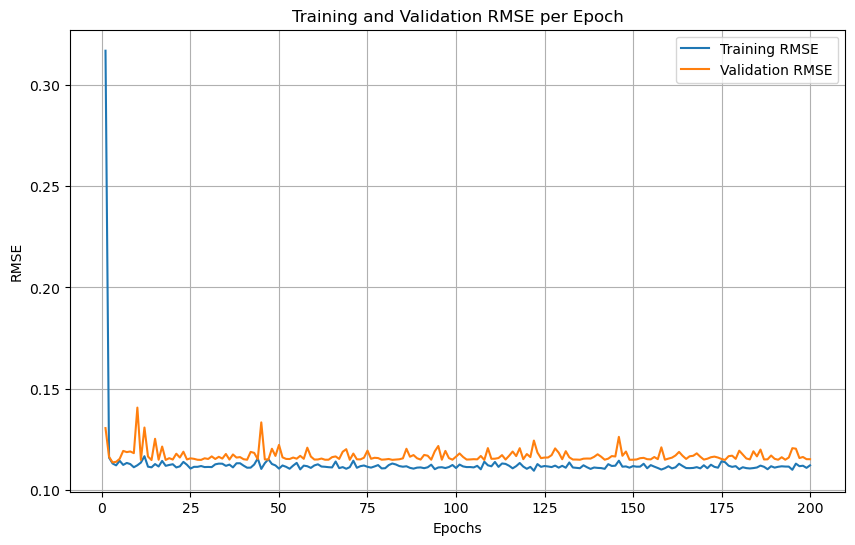

In [17]:
# Graficar pérdidas
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_summaries, label='Training RMSE')
plt.plot(epochs_range, valid_summaries, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('rmse_per_epoch.png') 
plt.show()

In [43]:
def plotImage(image_data):
    plt.figure()
    plt.imshow(image_data)
    plt.colorbar()
    plt.title('Imagen FITS')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.gca().invert_yaxis() 
    plt.savefig('Image-disk.png')
    plt.show()

def plotVelocity(v_real, v_model, pix):

    x = np.linspace(0, 300, pix)
    y = np.linspace(0, 300, pix)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, v_real)
    plt.colorbar(label='Velocidad FARGO3D')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Componente de Velocidad según FARGO3D')
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, v_model)
    plt.colorbar(label='Velocidad Model')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Componente de Velocidad según Model')
    
    plt.tight_layout()
    plt.savefig('Velocity-result-comparison.png')
    plt.show()

In [47]:
# Cargar el modelo entrenado para pruebas unitarias
model = ModelParallel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.load_state_dict(torch.load('modelo_entrenado.pth'), strict=False)
npix = 300
model.eval()
all_predictions = np.empty((0, *(npix, npix, 1)))
all_real = np.empty((0, *(npix, npix, 1)))
all_test_images = np.empty((0, *(14, npix, npix, 1)))
# Hacer predicciones
with torch.no_grad():
    for images, velocities in test_loader:
        predicciones = model(images.to('cuda:0'))
        loss = criterion(predicciones.to('cuda:3'), velocities.to('cuda:3'))
        print(loss)
        predicciones_cpu = predicciones.cpu().numpy()
        all_predictions = np.append(all_predictions, predicciones_cpu, axis=0)
        real_cpu = velocities.cpu().numpy()
        all_real = np.append(all_real, real_cpu, axis=0)
        image_cpu = images.cpu().numpy()
        all_test_images = np.append(all_test_images, image_cpu, axis=0)

print(predicciones_cpu.shape)
print(real_cpu.shape)
print(image_cpu.shape)
print(all_predictions.shape)
print(all_real.shape)
print(all_test_images.shape)

Densely Layer  --- in_channels , out_channels , input_num_DENSE_01 , num_labels ===>  1 64 --- 1
LSTMConv Layer  --- filters, kernel_size, padding,  input_num_DENSE_01 , num_layers ===>  128 (1, 1) (0, 0) --- 1
Densely Layer  --- in_channels , out_channels , input_num_DENSE_01 , num_labels ===>  128 128 --- 1
Densely Output Layer  --- in_channels , out_channels , input_num_DENSE_OUT_01 , num_labels ===>  128 1 --- 1
tensor(0.0081, device='cuda:3')
tensor(0.0175, device='cuda:3')
tensor(0.0057, device='cuda:3')
tensor(0.0155, device='cuda:3')
tensor(0.0438, device='cuda:3')
tensor(0.0196, device='cuda:3')
tensor(0.0210, device='cuda:3')
(2, 300, 300, 1)
(2, 300, 300, 1)
(2, 14, 300, 300, 1)
(14, 300, 300, 1)
(14, 300, 300, 1)
(14, 14, 300, 300, 1)


In [53]:
id = 0

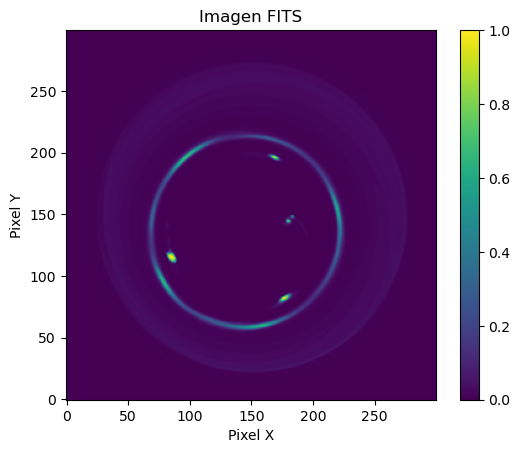

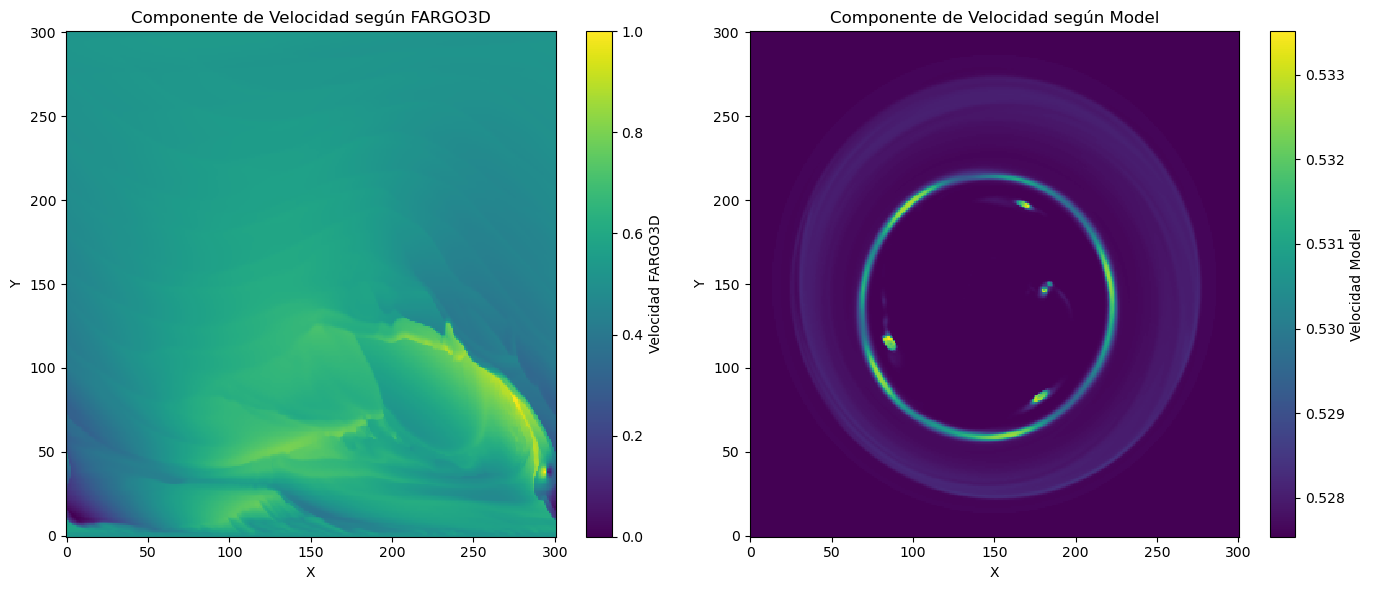

RMSE: 0.0919
MAE: 0.0641
SSIM: 0.8801


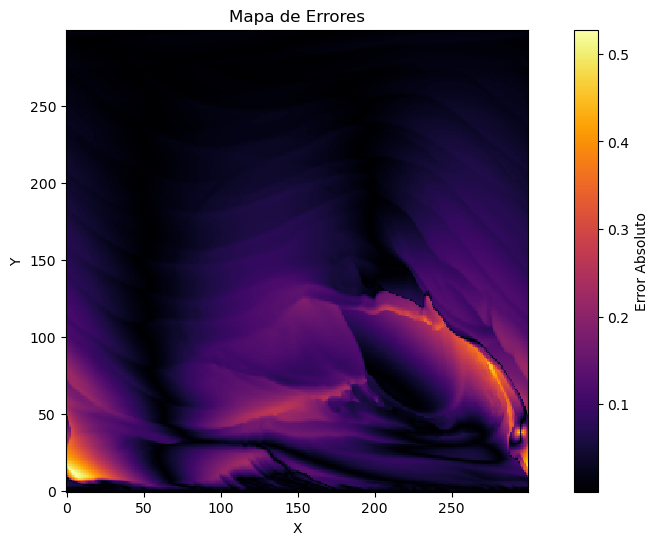

In [54]:
plotImage(all_test_images[id][9].reshape((300, 300)))
plotVelocity(all_real[id].reshape((300, 300)), all_predictions[id].reshape((300,300)), 300)
y_true = all_real[id].reshape((300, 300))
y_pred = all_predictions[id].reshape((300,300))

# Calcular RMSE
mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

# Calcular MAE
mae = np.mean(np.abs(y_true - y_pred))
print(f"MAE: {mae:.4f}")

# Calcular SSIM
from skimage.metrics import structural_similarity as ssim
ssim_index, _ = ssim(y_true, y_pred, data_range=y_true.max() - y_true.min(), full=True)
print(f"SSIM: {ssim_index:.4f}")

# Calcular el mapa de errores
error_map = np.abs(y_true - y_pred)

# Visualizar el mapa de errores
plt.figure(figsize=(12, 6))
plt.imshow(error_map, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Error Absoluto')
plt.title('Mapa de Errores')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis() 
plt.savefig('Error_Map.png')
plt.show()